<a href="https://colab.research.google.com/github/alicepearse/DL_prac/blob/master/SimpleRNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

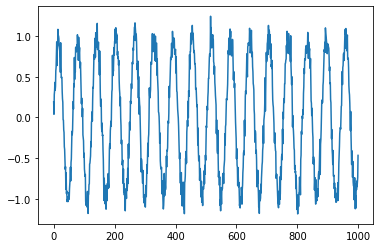

In [3]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# plot it
plt.plot(series)

In [6]:
# Build dataset
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [59]:
# Bulid the model
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.RNN(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        nonlinearity = 'relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, _ = self.rnn(X, h0)

    out = self.fc(out[:, -1, :])
    return out

In [60]:
# instantiate model
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [61]:
# Loss and optimzer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [62]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [63]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [64]:
# training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=1000):
  
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # backward and optimize
    loss.backward()
    optimizer.step()

    # save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it+1) %  5 == 0:
      print(f'Epoch {it + 1} / {epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [65]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5 / 1000, Train Loss: 0.4413, Test Loss: 0.4369
Epoch 10 / 1000, Train Loss: 0.4163, Test Loss: 0.4123
Epoch 15 / 1000, Train Loss: 0.3926, Test Loss: 0.3893
Epoch 20 / 1000, Train Loss: 0.3705, Test Loss: 0.3677
Epoch 25 / 1000, Train Loss: 0.3491, Test Loss: 0.3465
Epoch 30 / 1000, Train Loss: 0.3273, Test Loss: 0.3246
Epoch 35 / 1000, Train Loss: 0.3044, Test Loss: 0.3014
Epoch 40 / 1000, Train Loss: 0.2796, Test Loss: 0.2763
Epoch 45 / 1000, Train Loss: 0.2525, Test Loss: 0.2486
Epoch 50 / 1000, Train Loss: 0.2225, Test Loss: 0.2178
Epoch 55 / 1000, Train Loss: 0.1897, Test Loss: 0.1845
Epoch 60 / 1000, Train Loss: 0.1561, Test Loss: 0.1508
Epoch 65 / 1000, Train Loss: 0.1260, Test Loss: 0.1212
Epoch 70 / 1000, Train Loss: 0.1035, Test Loss: 0.0997
Epoch 75 / 1000, Train Loss: 0.0880, Test Loss: 0.0847
Epoch 80 / 1000, Train Loss: 0.0778, Test Loss: 0.0749
Epoch 85 / 1000, Train Loss: 0.0697, Test Loss: 0.0668
Epoch 90 / 1000, Train Loss: 0.0620, Test Loss: 0.0594
Epoch 95 / 

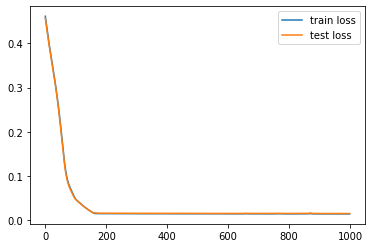

In [66]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [67]:
# one step forecasting - incorrect 
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

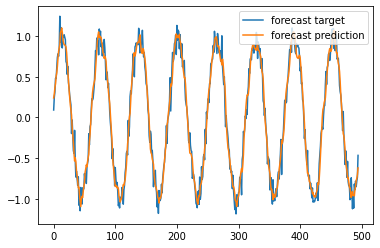

In [68]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [69]:
# multistep forecasting - correct
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))


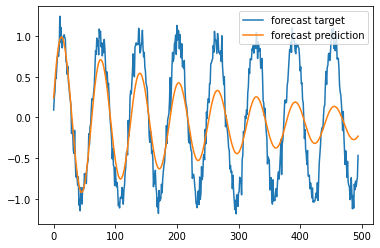

In [70]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()